In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()
using Test
using Plots
using JLD2
include("quadruped.jl") 
const resfile = joinpath(@__DIR__,"Q1.jld2")
const isautograder = @isdefined autograder

  Activating environment at `D:\Study_material\Grad_Courses\16745\HW2\homework2-Wenyu-Wu\Project.toml`


WebIO._IJuliaInit()

false

# Q1: Balancing the Quadruped with LQR (25 pts)
In this problem you'll stabilize the quadruped around the equilibrium point you found in the previous homework.

Note that we modified the model a little from the previous HW to make this problem easier. It now has once less degree of freedom (DOF), since we aren't allowing it to twist on the floor. Assuming we have "grippy" rubber feet, this isn't a bad assumption to make. This means it now has 28 states (14 positions, 14 velocities) and 12 controls.

The final result using an infinite-horizon controller should look like this:
![](../quadruped.gif)

## Part (a): Compute the optimal LQR gains using Riccati (8 pts)
As we saw in class, we can solve the LQR problem using a backward Riccati recursion, which also generates a locally-optimal feedback controller. Implement your own method to calculate a set of optimal feedback gains.

In [2]:
# Load the quadruped model
model = UnitreeA1()
n,m = state_dim(model), control_dim(model)
# Use the equilibrium point we found in HW1
xeq = [0.30876598892362367, -0.260133570638461, -0.09358998727238592, 0.7078311865326717, -0.41038927424745475, -0.3598290230260733, 0.35837932714316556, 0.3579443729935737, -0.52325974352618, -0.524349602250509, 0.5321637004468419, 0.17483502352564967, 0.1745288580720117, -0.17241139464042135, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ueq = [7.326746743908579, 12.492831761746691, -3.7276131797642345, -0.21210770886642585, 0.7228048164769122, 0.7061868479839222, -0.954088911642226, -0.8136046730618279, -0.5649940436402389, -0.273344715530589, -0.2382444936066465, -0.19338784324481662]
# Getting the discrete Dynamics and Jacobians (you'll need this!)
let time = 0.0, dt = 0.1, xeq = SVector{28}(xeq), ueq = SVector{12}(ueq)
    xnext = discrete_dynamics(RK4, model, xeq, ueq, time, dt)
    ∇f = discrete_jacobian(RK4, model, xeq, ueq, dt)
    A = ∇f.A
    B = ∇f.B
end

28×12 view(::Matrix{Float64}, :, 29:40) with eltype Float64:
  -1.44912      0.811258    0.10381      …    0.0840278      0.108648
   0.140132    -0.0782363  -0.0185027        -0.00637176    -0.0111547
   3.08184     -1.74167    -0.206909         -0.16805       -0.221372
  -1.74167      1.0079      0.122777          0.0864998      0.115302
  -0.206909     0.122777    0.174041          0.0299411     -0.00659528
   0.329043    -0.170687    0.159829     …   -0.00271012    -0.0469003
   0.234647    -0.14026     0.156059         -0.0164776     -0.0428785
  -0.050085     0.0491911   0.195289          0.0228467      0.00865357
  -0.165632     0.127838    0.0265937        -0.000995485   -0.00109963
   0.292473    -0.145186   -0.0261162        -0.931742      -0.0257604
   0.329389    -0.165056    0.000879338  …   -0.0242699     -0.873657
   0.0955391   -0.0724207  -0.0128118         0.000536941    0.00040919
  -0.16805      0.0864998   0.0299411         2.32619        0.0118182
   ⋮            

In [3]:
# TASK: Implement the following function (5 pts)
"""
    riccati(A,B,Q,R,Qf,N)

Use backward riccati recursion to solve the finite-horizon time-invariant LQR problem.
Returns vectors of the feedback gains `K` and cost-to-go matrices `P`, where `length(K) == N-1`,
`length(P) == N`, and `size(K[i]) == (m,n)` and `size(P[i]) == (n,n)`.

# Arguments:
* `A`: `(n,n)` discrete dynamics Jacobian wrt the state
* `B`: `(n,m)` discrete dynamics Jacobian wrt the control
* `Q`: `(n,n)` stage-wise cost matrix for states
* `R`: `(m,m)` stage-wise cost matrix for controls
* `Qf`: `(n,n)` cost matrix for terminal state
* `N`: Integer number of time steps (horizon length).
"""
function riccati(A,B,Q,R,Qf,N)
    # initialize the output
    n,m = size(B)
    P = [zeros(n,n) for k = 1:N]
    K = [zeros(m,n) for k = 1:N-1]
    
    # TODO: implement the Riccati recursion
    P[end] .= Qf
    for k = reverse(1:N-1) 
        K[k] .= (R + B'P[k+1]*B)\(B'P[k+1]*A)
        P[k] .= Q + A'P[k+1]*A - A'P[k+1]*B*K[k]
    end
    
    # return the feedback gains and ctg matrices
    return K,P
end

riccati

In [4]:
# TASK: Compute the optimal gains
#       Store the result in a matrix K::Vector{Matrix{Float64}}, where size(K[1]) = (12,28)
#       Use the cost matrices provided below

# Some parameters
dt = 0.01
tf = 2.0
times = range(0,tf,step=dt)
N = length(times)

# Define the LQR cost
Q = Diagonal([fill(130.,n÷2); fill(130.,n÷2)])
R = Diagonal(fill(10.0, m))
Qf = copy(Q)

# TODO: solve for the feedback gains
K = [zeros(0,0) for k = 1:N]
P = [zeros(0,0) for k = 1:N];

time = 0.0 
dt = 0.01 
xeq = SVector{28}(xeq)
ueq = SVector{12}(ueq)
xnext = discrete_dynamics(RK4, model, xeq, ueq, time, dt)
∇f = discrete_jacobian(RK4, model, xeq, ueq, dt)
A = ∇f.A
B = ∇f.B
K,P = riccati(A,B,Q,R,Qf,N)
xeq = [0.30876598892362367, -0.260133570638461, -0.09358998727238592, 0.7078311865326717, -0.41038927424745475, -0.3598290230260733, 0.35837932714316556, 0.3579443729935737, -0.52325974352618, -0.524349602250509, 0.5321637004468419, 0.17483502352564967, 0.1745288580720117, -0.17241139464042135, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ueq = [7.326746743908579, 12.492831761746691, -3.7276131797642345, -0.21210770886642585, 0.7228048164769122, 0.7061868479839222, -0.954088911642226, -0.8136046730618279, -0.5649940436402389, -0.273344715530589, -0.2382444936066465, -0.19338784324481662]
# K,P = riccati(A,B,Q,R,Qf,N)

12-element Vector{Float64}:
  7.326746743908579
 12.492831761746691
 -3.7276131797642345
 -0.21210770886642585
  0.7228048164769122
  0.7061868479839222
 -0.954088911642226
 -0.8136046730618279
 -0.5649940436402389
 -0.273344715530589
 -0.2382444936066465
 -0.19338784324481662

In [14]:
@testset "Q1a" begin  # POINTS = 8
    @test size(K[1]) == (12,28)  # POINTS = 1.5
    @test size(P[1]) == (28,28)  # POINTS = 1.5
    @test K ≈ load(resfile, "K") rtol=1e-4  # POINTS = 2
    @test P ≈ load(resfile, "P") rtol=1e-4  # POINTS = 3
end;

Test Summary: | Pass  Total
Q1a           |    4      4


## Part (b): Implement the LQR Controller (3 pts)
Now that we've computed our gains, let's implement a controller to use on our system!

In [5]:
# TASK: implement the following method
#       get_control
"""
    LQRController

Type for evaluting a time-invariant LQR control policy. If the `infinite_horizon`
field is true, it will only use a single gain, `K[1]`.
"""
struct LQRController
    K::Vector{Matrix{Float64}}   # feedback gains ((m,n),N-1)
    times::Vector{Float64}       # times          (N,)
    xeq::Vector{Float64}         # equilibrium states
    ueq::Vector{Float64}         # equilibrium controls
    infinite_horizon::Bool       # use infinite horizon control
end
function LQRController(K,xeq,ueq,tf, ih=false)
    LQRController(Matrix.(K), collect(range(0,tf,length=length(K)+1)), xeq, ueq, ih)
end

"""
    get_k(ctrl, t)

Get the time index corresponding to time `t`. 
Useful for implementing zero-order hold control.
Uses binary search to find the time index.
"""
get_k(controller::LQRController, t) = searchsortedlast(controller.times, t)

"""
    get_control(ctrl::TVLQR, x, t)

Evaluate the TVLQR feedback policy at state `x` and time `t`, returning the control 
to be executed by the system.
"""
function get_control(controller::LQRController, x, t)
    # TODO: Finish the function to calculate the control at time t
    idx = get_k(controller,t)
    K_vec = controller.K
    ctrl = ueq -K_vec[idx] * (x - xeq)
    return ctrl
end

get_control

In [6]:
# Create the controller
xeq = [0.30876598892362367, -0.260133570638461, -0.09358998727238592, 0.7078311865326717, -0.41038927424745475, -0.3598290230260733, 0.35837932714316556, 0.3579443729935737, -0.52325974352618, -0.524349602250509, 0.5321637004468419, 0.17483502352564967, 0.1745288580720117, -0.17241139464042135, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ueq = [7.326746743908579, 12.492831761746691, -3.7276131797642345, -0.21210770886642585, 0.7228048164769122, 0.7061868479839222, -0.954088911642226, -0.8136046730618279, -0.5649940436402389, -0.273344715530589, -0.2382444936066465, -0.19338784324481662]
ctrl = LQRController(K,xeq,ueq,tf);

In [14]:
@testset "Q1b" begin  # POINTS = 3
    xtest = xeq + [fill(0.1,14); fill(-0.1,14)]
    @test norm(get_control(ctrl, xeq, 0.0) - ueq) ≈ 0 atol=1e-10                   # POINTS = 0.5
    @test norm(get_control(ctrl, xeq, 1.0) - ueq) ≈ 0 atol=1e-10                   # POINTS = 0.5
    @test norm(get_control(ctrl, xtest, 0.0) - ueq) > 0                            # POINTS = 0.5
    @test norm(get_control(ctrl, xtest, 0.0) - get_control(ctrl, xtest, 1.0)) > 1  # POINTS = 0.5
    @test get_control(ctrl, xtest, 0.0) ≈ load(resfile, "utest0") rtol=1e-3        # POINTS = 0.5
    @test get_control(ctrl, xtest, 1.0) ≈ load(resfile, "utest1") rtol=1e-3        # POINTS = 0.5
end;

Test Summary: | Pass  Total
Q1b           |    6      6


## Part (c): Compute the infinite-horizon gain (6 pts)
In the previous question, we found a set of time-varying gains to stabilize our system. However, let's look at the behavior of our gains over time.

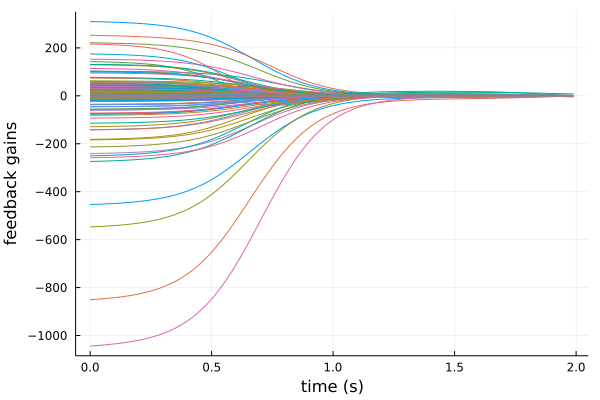

In [18]:
using Plots
Kmat = hcat(vec.(K)...);
if !isautograder
    plot(times[1:end-1], Kmat', legend=:none, xlabel="time (s)", ylabel="feedback gains")
end

It looks like they're starting to converge to some steady-state initial gain. Let's increase the length of our horizon and see what happens.

In [7]:
# TODO: Extend the horizon by at least 2x and save the new gains and cost-to-go in Kinf, Pinf (3pts)
Kinf,Pinf = deepcopy(K), deepcopy(P)

dt = 0.01
tf_ext = 4.0
times = range(0,tf_ext,step=dt)
N = length(times)

time = 0.0 
xeq = SVector{28}(xeq)
ueq = SVector{12}(ueq)
xnext = discrete_dynamics(RK4, model, xeq, ueq, time, dt)
∇f = discrete_jacobian(RK4, model, xeq, ueq, dt)
A = ∇f.A
B = ∇f.B

Kinf,Pinf = riccati(A,B,Q,R,Qf,N)

# Plot the result
Kmat = hcat(vec.(Kinf)...);
if !isautograder
    plot(Kmat', legend=:none, xlabel="time (s)", ylabel="feedback gains")
end

In [20]:
@testset "Q1c" begin                           # POINTS = 3
    @testset "Calc Kinf" begin                 # POINTS = 3
        @test length(Kinf) >= 2*length(K)                # POINTS = 0.5
        @test Kinf[1] ≈ load(resfile, "Kinf") rtol=1e-3  # POINTS = 1.5
        @test 0 < norm(Kinf[1] - Kinf[2]) < 1e-2             # POINTS = 0.5
        @test 0 < norm(Pinf[1] - Pinf[2]) < 3e3              # POINTS = 0.5
    end
end;

Test Summary: | Pass  Total
Q1c           |    4      4


You should be able to see that they're definitely converging to some steady-state initial value. This value is usually referred to as the "infinite horizon" gain, and is very useful in practice. It's common practice to use the associated cost-to-go matrix as the $Q_f$ weighting matrix in finite-horizon problems (we'll do this in Q3).

**TASK**: Tweak your controller code above so that if the `infinite_horizon` flag is true, it only uses the gains at the first time step. Then generate a new controller, `ctrl_inf` that only uses the infinite gain.

With both the finite and infinite-horizon controllers defined, let's see how they do on the system.

In [8]:
# TODO: create the infinite-horizon controller (3pts)
xeq = [0.30876598892362367, -0.260133570638461, -0.09358998727238592, 0.7078311865326717, -0.41038927424745475, -0.3598290230260733, 0.35837932714316556, 0.3579443729935737, -0.52325974352618, -0.524349602250509, 0.5321637004468419, 0.17483502352564967, 0.1745288580720117, -0.17241139464042135, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ueq = [7.326746743908579, 12.492831761746691, -3.7276131797642345, -0.21210770886642585, 0.7228048164769122, 0.7061868479839222, -0.954088911642226, -0.8136046730618279, -0.5649940436402389, -0.273344715530589, -0.2382444936066465, -0.19338784324481662]
tf = 2.0
# K_init = copy(K)
# len_K = size(K)[1]
# for i = 1:len_K
#     K_init[i] = K[1]
# end
ctrl_inf = LQRController([Kinf[1]],xeq,ueq,tf,true);

In [22]:
@testset "Q1c" begin                   # POINTS = 3
    @testset "Kinf Controller" begin   # POINTS = 3
        xtest = xeq + [fill(0.1,14); fill(-0.1,14)]
        @test get_control(ctrl_inf, xtest, 0.0) ≈ get_control(ctrl_inf, xtest, 1.0)     # POINTS = 1
        @test get_control(ctrl_inf, xtest, 0.0) ≈ load(resfile, "utest_inf") rtol=1e-4  # POINTS = 2
    end
end;

Test Summary: | Pass  Total
Q1c           |    2      2


## Part (d): Stability Analysis (3 pts)
Before we simulate, it's always a good idea to check the stability of our system. Evaluate the stability using the infinite-horizon gain and

In [9]:
# TASK: compute the stability of our original uncontrolled system (1.5 pts)
#       i.e. norm of largest eigenvalue
eig_A = eigvals(A)
eig_A_n = zeros(length(eig_A))
max_e = -Inf
for i = 1:length(eig_A)
    eig_A_n[i] = abs(eig_A[i])
    if (max_e < eig_A_n[i])
        max_e = eig_A_n[i]
    end
end
stability0 = max_e

# TASK: compute the stability of our new, controlled system (1.5 pts)
A_cl = A - B * Kinf[1]
eig_A = eigvals(A_cl)
eig_A_n = zeros(length(eig_A))
max_cl = -Inf
for i = 1:length(eig_A)
    eig_A_n[i] = abs(eig_A[i])
    if (max_cl < eig_A_n[i])
        max_cl = eig_A_n[i]
    end
end
stability = max_cl

0.9900571178395864

In [39]:
@testset "Q1d" begin                                          # POINTS = 3
    @test stability0 > 1                                      # POINTS = 1
    @test stability < stability0                              # POINTS = 0
    @test stability < 1                                       # POINTS = 1
    @test stability0 ≈ load(resfile, "stability0") rtol=1e-3  # POINTS = 0.5
    @test stability ≈ load(resfile, "stability") rtol=1e-3    # POINTS = 0.5
end;

Test Summary: | Pass  Total
Q1d           |    5      5


## Part (e): Simulate the Quadruped (5 pts)
Let's now put it all together and stabilize the quadruped.

In [18]:
# TASK: complete the simulator code (5 pts)
"""
    simulate(model, x0, controller; dt, tf, mvis)

Simulate the quadruped, starting from initial state `x0` and using `controller` to stabilize the system.

# Keyword Arguments
* `tf`: total simulation time
* `dt`: simulation time step
* `mvis`: if passed in, use the `MechanismVisualizer` to visualize the simulation while it's running
"""
function simulate(model::UnitreeA1, x0, controller; dt=0.05, tf=1.0, mvis=nothing)
    # some initialization
    xeq = [0.30876598892362367, -0.260133570638461, -0.09358998727238592, 0.7078311865326717, -0.41038927424745475, -0.3598290230260733, 0.35837932714316556, 0.3579443729935737, -0.52325974352618, -0.524349602250509, 0.5321637004468419, 0.17483502352564967, 0.1745288580720117, -0.17241139464042135, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    ueq = [7.326746743908579, 12.492831761746691, -3.7276131797642345, -0.21210770886642585, 0.7228048164769122, 0.7061868479839222, -0.954088911642226, -0.8136046730618279, -0.5649940436402389, -0.273344715530589, -0.2382444936066465, -0.19338784324481662]
    time = 0.0
    xeq = SVector{28}(xeq)
    ueq = SVector{12}(ueq)
#     xnext = discrete_dynamics(RK4, model, xeq, ueq, time, dt)
#     ∇f = discrete_jacobian(RK4, model, xeq, ueq, dt)
#     A = ∇f.A
#     B = ∇f.B
    
    time = range(0, tf, step=dt)
    n,m = state_dim(model), control_dim(model) 
    N = Int(round(tf/dt)) + 1
    X = [@SVector zeros(n) for k = 1:N] 
    U = [@SVector zeros(m) for k = 1:N-1] 
    
    # set the initial state
    X[1] = x0
    for k = 1:length(time) - 1
        # TODO: simulate the system with feedback
        U[k] = get_control(controller,X[k],time[k])
#         if (controller.infinite_horizon)
#             X[k+1] = (A-B*K[1])*X[k] + B*xeq
#         else
#             X[k+1] = (A-B*K[k])*X[k] + B*xeq
#         end
        X[k+1] = discrete_dynamics(RK4, model, X[k], U[k], time[k], dt)
        # visualization code
        if !isnothing(mvis)
            set_configuration!(mvis, X[k+1][1:14])
            sleep(dt)
        end
    end
    return X,U,time
end

simulate

In [11]:
if !isautograder
    mvis = initialize_visualizer(model)
    render(mvis)
end

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat C:\Users\ASUS\.julia\packages\MeshCat\Ax8pH\src\visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("world" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("dummy1" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6c, 0x64, 0x2f, 0x64, 0x75, 0x6d, 0x6d, 0x79, 0x31], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("RR_foot" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x79, 0x31, 0x2f, 0x52, 0x52, 0x5f, 0x66, 0x6f, 0x6f, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_RR_foot_fixed" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x66, 0x6f, 0x6f, 0x74, 0x5f, 0x66, 0x69, 0x78, 0x65, 0x64], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_15" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31, 0x35], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31, 0x35], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "RR_calf" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6f, 0x74, 0x2f, 0x52, 0x52, 0x5f, 0x63, 0x61, 0x6c, 0x66], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_RR_calf_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x63, 0x61, 0x6c, 0x66, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_14" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31, 0x34], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31, 0x34], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "RR_thigh" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x66, 0x2f, 0x52, 0x52, 0x5f, 0x74, 0x68, 0x69, 0x67, 0x68], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_RR_thigh_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x68, 0x69, 0x67, 0x68, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_13" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31, 0x33], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31, 0x33], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "RR_hip" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x67, 0x68, 0x2f, 0x52, 0x52, 0x5f, 0x68, 0x69, 0x70], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("trunk" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x5f, 0x68, 0x69, 0x70, 0x2f, 0x74, 0x72, 0x75, 0x6e, 0x6b], Dict{String, Vector{UIn

In [16]:
# Perturb the initial condition
x_init = copy(xeq)
x_init[18] -= 0.1
x_init[19] -= 0.05

-0.05

In [23]:
# Finite Horizon
X,U,times = simulate(model, x_init, ctrl, dt=dt, tf=tf);
isautograder || visualize!(mvis, model, time[end], X)  # send the trajectory to the visualizer

In [24]:
# Infinite horizon
# TIP: Your result should look very similar to the animation at the top of this file
Xinf,Uinf,times = simulate(model, x_init, ctrl_inf, dt=dt, tf=tf);
isautograder || visualize!(mvis, model, time[end], Xinf)  # send the trajectory to the visualizer

Let's take a look some plots.

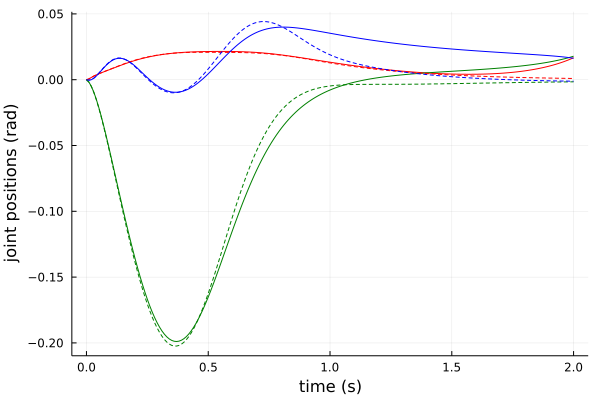

In [25]:
# Plot the response
c = [:red :green :blue]
dX = [x - xeq for x in X]
isautograder || plot(times,dX,inds=3:5, legend=:none, xlabel="time (s)", ylabel="joint positions (rad)", c=c)
dX2 = [x - xeq for x in Xinf]
isautograder || plot!(times, dX2, inds=3:5, legend=:none, colors=1:12, ls=:dash, c=c)

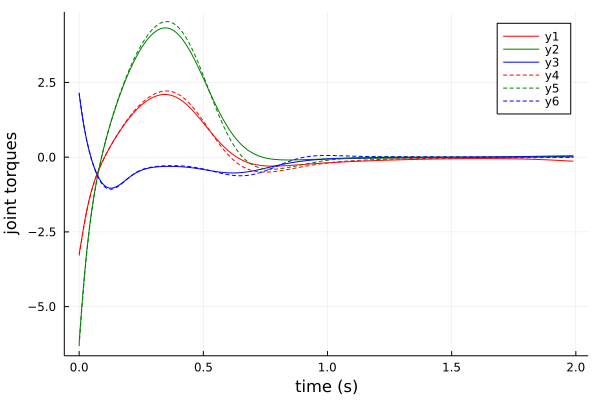

In [26]:
dU = [u - ueq for u in U]
isautograder || plot(times[1:end-1], dU, inds=1:3, xlabel="time (s)", ylabel="joint torques", c=c)
dU2 = [u - ueq for u in Uinf]
isautograder || plot!(times[1:end-1], dU2, inds=1:3, ls=:dash, c=c)

In [27]:
@testset "Q1e" begin                                      # POINTS = 5
    @test norm(X[end] - xeq) < 0.2                        # POINTS = 2
    @test norm(Xinf[end] - xeq) < 0.1                     # POINTS = 2
    @test norm(Xinf[end] - xeq) < norm(X[end] - xeq)      # POINTS = 1
end; 

Test Summary: | Pass  Total
Q1e           |    3      3
